# Case 1

## Import libraries

In [209]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

import scipy . linalg as lng # linear algebra from scipy library
from sklearn import preprocessing as preproc # preprocessing from sklearn library

from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV


from scipy . spatial import distance # load distance function
from sklearn import preprocessing as preproc # load preprocessing function

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV


## Load data

In [211]:
# Path to the data files
data_path_1 = '../data/case1Data.csv'
data_path_2 = '../data/case1Data_Xnew.csv'

# Load the data into a numpy array
data_np = np.loadtxt(data_path_1, delimiter=',', skiprows=1)
data_np_new = np.loadtxt(data_path_2, delimiter=',', skiprows=1)

# Print the shape of the data in the numpy array
print(data_np.shape) # 100 rows and 101 columns (100 features and 1 target)
print(data_np_new.shape) # 1000 rows and 100 columns (100 features and no target)

# Create a pandas dataframe and use the first row as the column names
data_pd = pd.read_csv(data_path_1, sep=',', header=0)
data_pd_new = pd.read_csv(data_path_2, sep=',', header=0)

# Print the shape of the data in the pandas dataframe
print(data_pd.shape)
print(data_pd_new.shape)

(100, 101)
(1000, 100)
(100, 101)
(1000, 100)


## Data wrangling

### Splitting the data into train and test

In [212]:
# Split the data into features and target
X = data_pd.iloc[:, 1:]
y = data_pd.iloc[:, 0]

print("X: ", X.shape)
print("y: ", y.shape)

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X:  (100, 100)
y:  (100,)


### Handling missing values

Possible methods:
- Drop rows
- Imputation: Mean, Median, Mode
- Interolation: Linear, Quadratic
- K-Nearest Neighbors (KNN)

In [213]:
# Use KNNImputer from scikit-learn to impute the missing values in the data with the mean of the k-nearest neighbors

# class sklearn.impute.KNNImputer(*, missing_values=nan, n_neighbors=5, weights='uniform', metric='nan_euclidean', copy=True, add_indicator=False, keep_empty_features=False)
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)

# Fit the imputer on the data and transform the data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

## Convert back into a pandas dataframe
#data_imputed = pd.DataFrame(data_imputed, columns=data_pd.columns)
#data_new_imputed = pd.DataFrame(data_new_imputed, columns=data_pd_new.columns)
#
## Print the shape of the imputed data
##print(data_imputed.shape)
##print(data_new_imputed.shape)

### One-hot encoding of categorical variables

In [ ]:
# Round the last 5 columns to a whole number
X_train_imputed.iloc[:, -5:] = np.round(X_train_imputed.iloc[:, -5:])
X_test_imputed.iloc[:, -5:] = np.round(X_test_imputed.iloc[:, -5:])

# Convert the data back to a pandas dataframe
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# One hot encode the data
X_train_imputed_encoded = pd.get_dummies(pd.DataFrame(X_train_imputed, columns=X_train_imputed.columns[-5:], dtype=int))
X_test_imputed_encoded = pd.get_dummies(pd.DataFrame(X_test_imputed, columns=X_train_imputed.columns[-5:], dtype=int))

print("X_train_imputed_encoded: ", X_train_imputed_encoded.shape)
print("X_test_imputed_encoded: ", X_test_imputed_encoded.shape)

print(X_train_imputed_encoded)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

### Standardization of numerical features

In [200]:
# Convert the numerical columns to float before applying standardization
X_train.iloc[:, :-36] = X_train.iloc[:, :-36].astype(float)

# Standardizing the numerical features and targets: z = (x - u) / sd
scaler = preproc.StandardScaler()
X_train.iloc[:, :-36] = scaler.fit_transform(X_train.iloc[:, :-36])
X_test.iloc[:, :-36] = scaler.fit_transform(X_test.iloc[:, :-36])
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.fit_transform(y_test.values.reshape(-1, 1))

In [201]:
# One-hot encode only the last 5 columns of the imputed data
data_imputed = pd.get_dummies(data_imputed, columns=data_imputed.columns[-5:], dtype=int)

# Convert the numerical columns to float before applying standardization
data_imputed.iloc[:, :-36] = data_imputed.iloc[:, :-36].astype(float)

# Standardizing the numerical features and targets: z = (x - u) / sd
scaler = preproc.StandardScaler()
data_imputed.iloc[:, :-36] = scaler.fit_transform(data_imputed.iloc[:, :-36])

# Save the imputed data to a csv file
np.savetxt('../data/case1Data_imputed.csv', data_imputed, delimiter=',')
np.savetxt('../data/case1Data_Xnew_imputed.csv', data_new_imputed, delimiter=',')

# First column is the target variable
y = data_imputed.iloc[:, 0]

# X is the feature matrix (all columns except the first)
X = data_imputed.iloc[:, 1:]

# Number of observations and number of features
[n, p] = X.shape
print("Number of observations: ", n)
print("Number of features (including one-hot encoded columns):", p)

Number of observations:  100
Number of features (including one-hot encoded columns): 121


## Feature selection

## Building models

OLS fra Anton:

In [202]:
def ols_solver(X, y):
    betas, res, rnk, s = lng.lstsq(X, y)
    
    return betas, res, rnk, s

#Estimate the model parameters
betas, residuals, rnk, s = ols_solver(X_train, y_train)

#Calculate y_hat
y_hat = X_test @ betas

res_solv_man = (y_test - y_hat) ** 2    
mse = np.mean(res_solv_man)

print(f'MSE: {mse}') # lng.lstsq returns sum of squared residuals, so we divide by num of obs to get mean

print(f'Root MSE: {np.sqrt(mse)}')

rss = np.sum(res_solv_man)
print(f'Residual sum of squares: {rss}')

tss = np.sum((y - np.mean(y))** 2)
print(f'Total sum of squares: {tss}')

r2 = (1 - rss / tss) * 100
print(f'R2: {r2}')

ValueError: array must not contain infs or NaNs

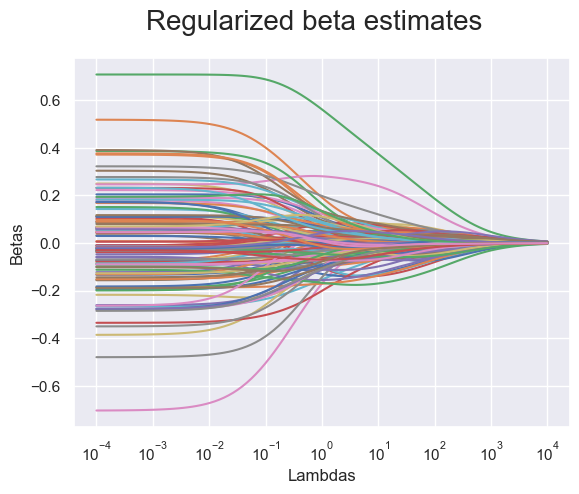

In [ ]:
def ridgeMulti(X, _lambda, p, y):
    inner_prod = np.linalg.inv(X.T @ X + _lambda * np.eye(p,p))
    outer_prod = X.T @ y
    betas = inner_prod @ outer_prod
    return betas
k = 100; # try k values of lambda
lambdas = np.logspace(-4, 4, k)

betas = np.zeros((p,k))

for i in range(k):
    betas[:, i] = ridgeMulti(X, lambdas[i], p, y)
    
plt.figure()
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle("Regularized beta estimates", fontsize=20)
plt.show()


In [ ]:
# Perform RidgeCV with 10-fold cross-validation
ridge_cv = RidgeCV(alphas=lambdas, store_cv_values=False, cv=10)
ridge_cv.fit(X_train, y_train)

# Optimal lambda
lambda_OP = ridge_cv.alpha_

#print optimal lambda
print(f'Optimal lambda: {lambda_OP}')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Optimal lambda: 12.328467394420684


In [ ]:
# Estimate mse with optimal lambda
y_hat = ridge_cv.predict(X_test)
mse = np.mean((y_test - y_hat) ** 2)
rmse = np.sqrt(mse)
print(f'Root MSE from OLS with ridge regression and cross validation (RidgeCV): {rmse}')

Root MSE from OLS with ridge regression and cross validation (RidgeCV): 0.5248285415431554


## Random Forest

In [ ]:
# Initialize RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE for random forest: {rmse:.4f}')

Test RMSE for random forest: 0.9363


### + AdaBoost

In [ ]:
## Define parameter grid
#param_grid = {
#    'n_estimators': range(10, 200, 10),
#    'estimator__max_depth': range(1, 21),
#    'learning_rate': np.logspace(-2, 0, 10),
#}
#
## Create an AdaBoostRegressor with a DecisionTreeRegressor as the base estimator
#boost = AdaBoostRegressor(estimator=DecisionTreeRegressor(), learning_rate=1)
#
## Perform grid search with 5-fold cross-validation
#boost_grid = GridSearchCV(boost, param_grid=param_grid, cv=5, verbose=0, n_jobs=-1, scoring='neg_mean_squared_error')
#
## Fit the model
#boost_grid.fit(X_train, y_train)
#
## Get best parameters and score
#best_params = boost_grid.best_params_
#best_score = -boost_grid.best_score_  # Convert back to positive MSE
#
## Use the best model to make predictions
#y_pred = boost_grid.predict(X_test)
#
## Evaluate the model
#rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#print(f'Test RMSE for AdaBoost: {rmse:.4f}')

KeyboardInterrupt: 

In [ ]:
# Define parameter distributions
param_dist = {
    'n_estimators': range(10, 200, 10),  # Finer granularity in useful range
    'estimator__max_depth': range(1, 21),  # Avoid deep trees for small sample sizes
    'learning_rate': np.logspace(-2, 0, 10),  # Log-spaced learning rates from 0.01 to 1
}

# Create AdaBoostRegressor with DecisionTreeRegressor as base estimator
boost = AdaBoostRegressor(estimator=DecisionTreeRegressor())

# Use RandomizedSearchCV for efficiency
boost_search = RandomizedSearchCV(
    boost,
    param_distributions=param_dist,
    n_iter=30,  # Adjust based on computational resources
    cv=5,
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=42
)

# Fit the model
boost_search.fit(X, y)

# Get best parameters and score
best_params = boost_search.best_params_
best_score = -boost_search.best_score_  # Convert back to positive MSE

# Use the best model to make predictions
y_pred = boost_grid.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE for AdaBoost: {rmse:.4f}')


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 155, 'learning_rate': 1.0, 'estimator__max_depth': 14}
Best MSE: 0.36463785424835243


## KNN

Average values of K-nearest neighbors

In [ ]:
def knn(K, X, n):
    yhat = np.zeros(n)
    distances = np.zeros(n)
    # For each obs, compare distance to all other points in X
    for i in range(n):
        for j in range(n):
            distances[j] = distance.euclidean(X[i,:], X[j, :])

        # Sort all the distances
        idx = np.argsort(distances)[1:(K + 1)] # Skip first, as distance to "itself" does not make sense

        yhat[i] = np.mean(y[idx]) # Final value is mean of nearest neighbors
        
    return yhat

K = 5 # number of neighbours
yhat = knn(K, X, n)
mse = np.mean((y-yhat) ** 2)
# test implementation
print(f'MSE value for K = {K} is: {mse}')

MSE value for K = 5 is: 0.9277900711262045


In [ ]:
def weighted_knn(K, X, n):
    yhat = np.zeros(n)
    distances = np.zeros(n)
    # For each obs, compare distance to all other points in X
    for i in range(n):
        for j in range(n):
            distances[j] = distance.euclidean(X[i,:], X[j, :])

        # Sort all the distances
        idx = np.argsort(distances)[1:(K + 1)] # Skip first, as distance to "itself" does not make sense
        Wt = sum(distances[idx]) # Weight of k nearest neighbors
        W = distances[idx] / Wt # Weighing average

        yhat[i] = np.matmul(W.T, y[idx]) # Final value is weighted combination of neighbours
    
    return yhat

K = 5 # number of neighbours
yhat = weighted_knn(K, X, n)
mse = np.mean((y-yhat) ** 2)
# test implementation
print(f'MSE value for K = {K} is: {mse}')

MSE value for K = 5 is: 0.9254351664103421


MSE value for K = 1 is: 1.6810006937744422
MSE value for K = 2 is: 1.1223769291172114
MSE value for K = 3 is: 1.0674711790807117
MSE value for K = 4 is: 0.9988907853959129
MSE value for K = 5 is: 0.9277900711262045
MSE value for K = 6 is: 0.9166823229487879
MSE value for K = 7 is: 0.8772599018168795
MSE value for K = 8 is: 0.8913033285576388
MSE value for K = 9 is: 0.8853694059768771
MSE value for K = 10 is: 0.9198886494550605
MSE value for K = 11 is: 0.8998989872099773
MSE value for K = 12 is: 0.8950338452320991
MSE value for K = 13 is: 0.8806989984503599
MSE value for K = 14 is: 0.8547153763141805
MSE value for K = 15 is: 0.862818926468324
MSE value for K = 16 is: 0.8470151393815618
MSE value for K = 17 is: 0.8660826833776311
MSE value for K = 18 is: 0.8650692993717118
MSE value for K = 19 is: 0.8708559013723629
MSE value for K = 20 is: 0.8799831832982803

K = 16 has the lowest MSE: 0.8470151393815618


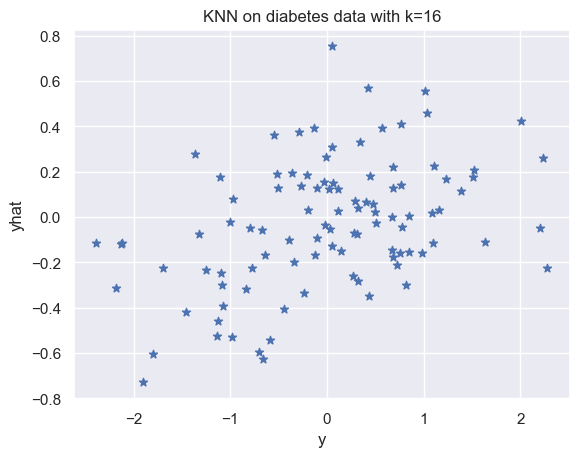

In [ ]:
mse_values = [] #to store mse values for different k

for k in range (1,21):
    yhat = knn(k, X, n)
    mse = np.mean((y-yhat) ** 2)
    mse_values.append(mse)
    print(f'MSE value for K = {k} is: {mse}')


k_best = mse_values.index(np.min(mse_values)) + 1
print(f'\nK = {k_best} has the lowest MSE: {np.min(mse_values)}')

yhat = knn(k_best, X, n)
plt.scatter(y, yhat, marker = "*")
plt.xlabel("y")
plt.ylabel("yhat")
plt.title(f'KNN on diabetes data with k={k_best}')
plt.show()

## Regression Tree

In [ ]:
# create a decisiontreeregressor/classifier
dtree = DecisionTreeRegressor()

# Fit the tree regressor/classifier
dtree.fit(X_train, y_train)

# Predict the target variable
y_pred = dtree.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

# Create a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, max_features='sqrt')

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {rmse}')

rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

Mean squared error: 0.5502977152617332
MSE: 0.9363445672932865
RMSE: 0.9148705391705322
